Load packages and models

In [1]:
from datetime import datetime
from efficientnet_pytorch import EfficientNet
from torch import nn
import pandas as pd
import pandas_path
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image as pil_image
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from PIL import Image as pil_image
import random
from torch.nn import functional as F
import cv2
import sys
from Datalaoder_resv2 import DatasetWIND

import sklearn.model_selection
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn.utils.rnn import pad_packed_sequence as unpack
from sklearn import preprocessing
from torchvision.models.video import r3d_18

torch.backends.cudnn.benchmark=True

In [2]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        model=r3d_18(pretrained=True)
        
        model.fc=nn.Identity()
        
        self.cnn = model
        self.fc1 = nn.Linear(512+25, 1)
        #self.fc2 = nn.Linear(64, 1)
        #self.bn  = nn.BatchNorm1d(64)
        
    def forward(self, image, data, time):
        x1 = self.cnn(image)
        x2 = data
        x3 = time
        
        
        x = torch.cat((x1,x2,x3), dim=1)
        x = F.leaky_relu(self.fc1(x))
        #x = self.bn(x)
        #x = F.leaky_relu(self.fc2(x))
        
        
        return x
        

cnn = MyModel()

load weights

In [3]:
cp=torch.load(r'G:\HU\model\r3d_2021-01-31 15-54-12_62.428912899738705.pt',map_location=('cuda:0'))


cnn.load_state_dict(cp["state_dict"])


cnn.eval()

MyModel(
  (cnn): VideoResNet(
    (stem): BasicStem(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), s

Load validation Data

In [4]:
DATA_PATH =r'G:\HU\Data'

DATA_PATH2 =r'C:\Users\Michael\Desktop\ML'

train_metadata = pd.read_csv(DATA_PATH + "/training_set_features.csv")
train_labels = pd.read_csv(DATA_PATH +"/training_set_labels.csv")

full_metadata = train_metadata.merge(train_labels, on="image_id")

full_metadata["file_name"] = (
    DATA_PATH2 + "/train/" + full_metadata.image_id.path.with_suffix(".jpg")
)

images_per_storm = full_metadata.groupby("storm_id").size().to_frame("images_per_storm")
full_metadata = full_metadata.merge(images_per_storm, how="left", on="storm_id")

storm_counts = train_metadata.groupby("storm_id").size()
df=pd.DataFrame(storm_counts,columns=["counts"]).reset_index()
df["class"]=1*(df.counts>100)+1*(df.counts>200)+1*(df.counts>300)+1*(df.counts>400)+1*(df.counts>500)+1*(df.counts>600)

sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1,  test_size=0.2,random_state=999)
split = sss.split(df, df["class"])

for a,b in split:
    IDs_train=df.iloc[a].storm_id
    IDs_val=df.iloc[b].storm_id

train=full_metadata[full_metadata["storm_id"].isin(IDs_train)].drop(
    ["images_per_storm",], axis=1
)
val=full_metadata[full_metadata["storm_id"].isin(IDs_val)].drop(
    ["images_per_storm",], axis=1
)  
    
print(train.head())
print(val.head())

  image_id storm_id  relative_time  ocean  wind_speed  \
0  abs_000      abs              0      2          43   
1  abs_001      abs           1800      2          44   
2  abs_002      abs           5400      2          45   
3  abs_003      abs          17999      2          52   
4  abs_004      abs          19799      2          53   

                                       file_name  
0  C:\Users\Michael\Desktop\ML/train/abs_000.jpg  
1  C:\Users\Michael\Desktop\ML/train/abs_001.jpg  
2  C:\Users\Michael\Desktop\ML/train/abs_002.jpg  
3  C:\Users\Michael\Desktop\ML/train/abs_003.jpg  
4  C:\Users\Michael\Desktop\ML/train/abs_004.jpg  
   image_id storm_id  relative_time  ocean  wind_speed  \
57  acd_000      acd              0      1          30   
58  acd_001      acd           1800      1          30   
59  acd_002      acd           3600      1          30   
60  acd_003      acd           5400      1          30   
61  acd_004      acd          12598      1          30   

  

In [5]:
names=[]
for j in range(23):
     name="image"+str(j)
     names.append(name)
targets={x:"image" for x in names}


transform_val=A.Compose(
            [
                A.transforms.CenterCrop(114,114,always_apply=True),
                A.transforms.Normalize (mean=(0.43216, 0.394666, 0.37645, ), std=(0.22803, 0.22145, 0.216989, ),max_pixel_value=255.0, always_apply=False, p=1.0),
                ToTensorV2()
            ],
                additional_targets=targets
        )

In [6]:
Batchsize=16
val_set=DatasetWIND(x_train=val.drop("wind_speed",axis=1),transform=transform_val,y_train=val["wind_speed"])
valloader=torch.utils.data.DataLoader(val_set,batch_size=Batchsize,shuffle=False,num_workers=8,pin_memory=False)



Validation loop 

In [7]:
def valLoop(dataloader,model):
    loop=tqdm(enumerate(dataloader, 0),total=len(dataloader),position=0, leave=True)
    df=pd.DataFrame(columns=["image_id","Prediction","WSPD",])
               
    model.cuda()
    model.eval()
    with torch.no_grad():
        for i, data in loop:
            # get the inputs; data is a list of [inputs, labels]
            inputs_val = data["image"].cuda()
            labels_val = data["label"].float().view(-1,1).cuda()
            ocean_val = data["ocean"].float().view(-1,1).cuda()
            time_val = data["time"].cuda()

            outputs_val = model(image=inputs_val,data=ocean_val,time=time_val)
            


            d={"image_id":data["image_id"],
               "Prediction":outputs_val.cpu().detach().numpy().flatten(),
               "WSPD":labels_val.cpu().detach().numpy().flatten()}
            df2=pd.DataFrame(d)
            df=df.append(df2)

            # print statistics
            

    df=df.merge(val.drop("wind_speed",axis=1),how='left',on="image_id")
    df["MSE"]=(df["Prediction"]-df["WSPD"])**2
    X_plot = np.linspace(20, 140, 100)
    plt.plot(X_plot, X_plot, color='r')
    sns.scatterplot(data=df, x="WSPD", y="Prediction", hue="ocean",palette="deep")   
    plt.show()

    return df

100%|██████████| 877/877 [05:21<00:00,  2.73it/s]


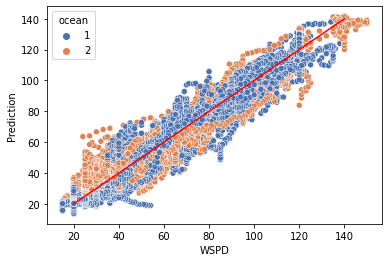

In [8]:
df_res=valLoop(valloader,cnn)

In [9]:
np.mean(df_res["MSE"])

62.4117

In [10]:
def average_smooth(df,h,test=False,mode="mean"):
    
    df2=df.copy()
    df2["Prediction_sm_9h"]=df2["Prediction"]

    n=df2.shape[0]
    k=df2.shape[1]

    for s in range(n):
        storm_id=df2["storm_id"][s]
        time=df2["relative_time"][s]
        time_min=np.max([0,time-60*60*h])
        filt=(df2["storm_id"]==storm_id) & (df2["relative_time"]>=time_min) & (df2["relative_time"]<=time)
        
        if mode == "median":
            df2.iloc[s,k-1]=np.median(df2[filt]["Prediction"])
        elif mode == "linreg":
            LR = LinearRegression()
            
            Y  = df2[filt]["Prediction"].values.reshape(-1, 1)
            X  = df2[filt]["relative_time"].values.reshape(-1, 1)
            j  = X.shape[0]
            
            if j>2:
                LR.fit(X,Y)
                df2.iloc[s,k-1]=LR.predict(time.reshape(1, -1))[0][0]
            else:
                df2.iloc[s,k-1]=np.mean(Y)
        else:
            df2.iloc[s,k-1]=np.mean(df2[filt]["Prediction"])
        
    if test==False:
        df2["MSE_sm"]=(df2["Prediction_sm_9h"]-df2["WSPD"])**2
        
    return(df2)


In [11]:
df_val=df_res

In [12]:
df_val_3=average_smooth(df=df_val,h=3)
df_val_6=average_smooth(df=df_val,h=6)
df_val_9=average_smooth(df=df_val,h=9)
df_val_12=average_smooth(df=df_val,h=12)

In [13]:
MSE_sm_3=np.mean(df_val_3["MSE_sm"])
print("MSE sm 3 = ",MSE_sm_3)

MSE_sm_6=np.mean(df_val_6["MSE_sm"])
print("MSE sm 6 = ",MSE_sm_6)

MSE_sm_9=np.mean(df_val_9["MSE_sm"])
print("MSE sm 9 = ",MSE_sm_9)

MSE_sm_12=np.mean(df_val_12["MSE_sm"])
print("MSE sm 12 = ",MSE_sm_12)

MSE sm 3 =  64.426315
MSE sm 6 =  68.90254
MSE sm 9 =  75.37268
MSE sm 12 =  83.5697


In [14]:
MSE_val=np.mean(df_val["MSE"])
print("MSE total  = ",MSE_val)

MSE_val_1=np.mean(df_val[df_val["ocean"]==1]["MSE"])
print("MSE ocean1 = ",MSE_val_1)

MSE_val_2=np.mean(df_val[df_val["ocean"]==2]["MSE"])
print("MSE ocean2 = ", MSE_val_2)

MSE total  =  62.4117
MSE ocean1 =  55.927975
MSE ocean2 =  74.4209


In [6]:
cnn1 = MyModel()
cnn2 = MyModel()
cnn3 = MyModel()
cnn4 = MyModel()
#cnn5 = MyModel()

In [7]:
cp1=torch.load(r'G:\HU\model\r3d_2021-01-31 03-35-34_63.153615421107695.pt',map_location=('cuda:0'))
cp2=torch.load(r'G:\HU\model\r3d_2021-01-31 06-34-31_64.37651003675583.pt',map_location=('cuda:0'))
cp3=torch.load(r'G:\HU\model\r3d_2021-01-31 09-21-53_64.26627026460109.pt',map_location=('cuda:0'))
cp4=torch.load(r'G:\HU\model\r3d_2021-01-31 18-35-16_61.78839567553284.pt',map_location=('cuda:0'))
#cp5=torch.load(r'G:\HU\model\r3d_2021-01-30 01-22-10_67.20687410065688.pt',map_location=('cuda:0'))


cnn1.load_state_dict(cp1["state_dict"])
cnn2.load_state_dict(cp2["state_dict"])
cnn3.load_state_dict(cp3["state_dict"])
cnn4.load_state_dict(cp4["state_dict"])
#cnn5.load_state_dict(cp5["state_dict"])

del cp, cp1, cp2 ,cp3, cp4
torch.cuda.empty_cache()

In [9]:
transform_val2=A.Compose(
            [
                A.transforms.CenterCrop(112,112,always_apply=True),
                A.transforms.Normalize (mean=(0.43216, 0.394666, 0.37645, ), std=(0.22803, 0.22145, 0.216989, ),max_pixel_value=255.0, always_apply=False, p=1.0),
                ToTensorV2()
            ],
                additional_targets=targets
        )
Batchsize=16
val_set2=DatasetWIND(x_train=val.drop("wind_speed",axis=1),transform=transform_val2,y_train=val["wind_speed"])
valloader2=torch.utils.data.DataLoader(val_set2,batch_size=Batchsize,shuffle=False,num_workers=8,pin_memory=False)

100%|██████████| 877/877 [04:49<00:00,  3.03it/s]


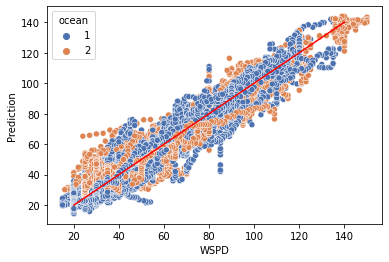

100%|██████████| 877/877 [05:13<00:00,  2.80it/s]


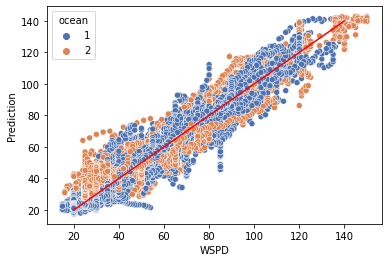

100%|██████████| 877/877 [05:16<00:00,  2.77it/s]


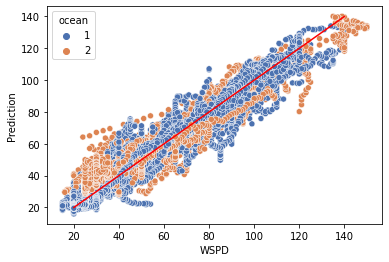

In [18]:
df_val1=valLoop(valloader2,cnn1)
df_val2=valLoop(valloader,cnn2)
df_val3=valLoop(valloader,cnn3)


100%|██████████| 877/877 [07:48<00:00,  1.87it/s]


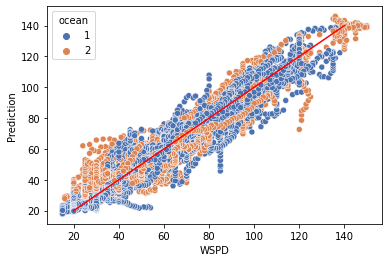

In [29]:
df_val4=valLoop(valloader,cnn4)

In [20]:
MSE_val1=np.mean(df_val1["MSE"])
print("MSE total  = ",MSE_val1)

MSE_val2=np.mean(df_val2["MSE"])
print("MSE total  = ",MSE_val2)

MSE_val3=np.mean(df_val3["MSE"])
print("MSE total  = ",MSE_val3)

MSE total  =  63.078876
MSE total  =  64.340546
MSE total  =  64.23784


In [21]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

59.87813

In [22]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

59.434532

In [23]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

59.164185

In [31]:
np.sqrt(58.810165)

7.668778585928791

In [30]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val4[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

58.810165

In [10]:
transform_rot=A.Compose(
            [
                A.transforms.CenterCrop(114,114,always_apply=True),
                A.augmentations.transforms.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=180,p=0.5),
                A.transforms.Normalize (mean=(0.43216, 0.394666, 0.37645, ), std=(0.22803, 0.22145, 0.216989, ),max_pixel_value=255.0, always_apply=False, p=1.0),
                ToTensorV2()
            ],
                additional_targets=targets
        )

val_rot=DatasetWIND(x_train=val.drop("wind_speed",axis=1),transform=transform_rot,y_train=val["wind_speed"])
rotloader=torch.utils.data.DataLoader(val_rot,batch_size=Batchsize,shuffle=False,num_workers=8,pin_memory=False)

100%|██████████| 877/877 [07:42<00:00,  1.89it/s]


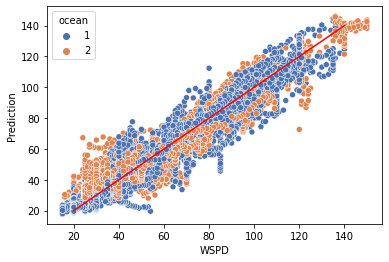

100%|██████████| 877/877 [06:35<00:00,  2.22it/s]


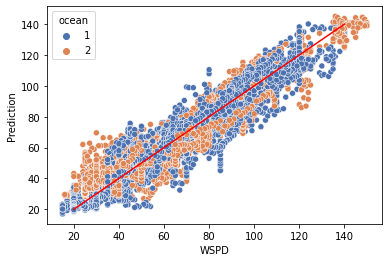

100%|██████████| 877/877 [06:25<00:00,  2.28it/s]


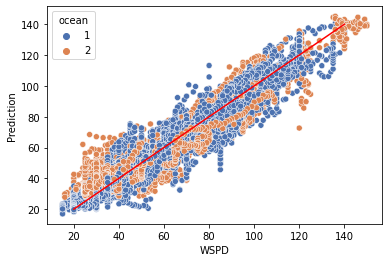

100%|██████████| 877/877 [06:19<00:00,  2.31it/s]


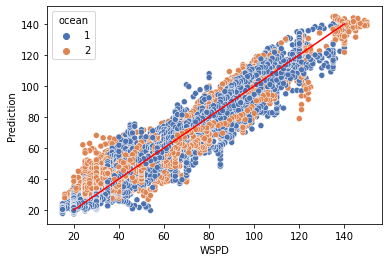

100%|██████████| 877/877 [06:17<00:00,  2.33it/s]


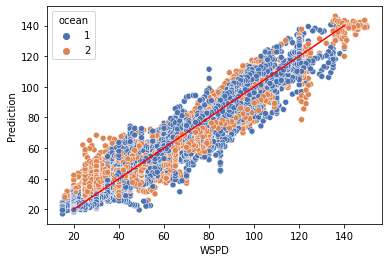

In [33]:
df_rot1=valLoop(rotloader,cnn4)
df_rot2=valLoop(rotloader,cnn4)
df_rot3=valLoop(rotloader,cnn4)
df_rot4=valLoop(rotloader,cnn4)
df_rot5=valLoop(rotloader,cnn4)

In [34]:
MSE_rot1=np.mean(df_rot1["MSE"])
print("MSE total  = ",MSE_rot1)

MSE_rot2=np.mean(df_rot2["MSE"])
print("MSE total  = ",MSE_rot2)

MSE_rot3=np.mean(df_rot3["MSE"])
print("MSE total  = ",MSE_rot3)

MSE_rot4=np.mean(df_rot4["MSE"])
print("MSE total  = ",MSE_rot4)

MSE_rot5=np.mean(df_rot5["MSE"])
print("MSE total  = ",MSE_rot5)

MSE total  =  62.848175
MSE total  =  62.51208
MSE total  =  63.110954
MSE total  =  62.038532
MSE total  =  62.21382


In [35]:
df_val=df_val4[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_rot1[["image_id","Prediction"]],how="left",on="image_id")




df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

61.218395

In [36]:
df_val=df_val4[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_rot1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot2[["image_id","Prediction"]],how="left",on="image_id")



df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

60.622536

In [37]:
df_val=df_val4[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_rot1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot3[["image_id","Prediction"]],how="left",on="image_id")


df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

60.41441

In [38]:
df_val=df_val4[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_rot1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot4[["image_id","Prediction"]],how="left",on="image_id")

df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

60.100597

In [39]:
df_val=df_val4[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_rot1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot4[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot5[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

59.889206

In [41]:
df_val=df_val4[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_rot1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot4[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_rot5[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val3[["image_id","Prediction"]],how="left",on="image_id")

df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

58.554886

In [42]:
df_val_3=average_smooth(df=df_val_comb,h=3)
df_val_6=average_smooth(df=df_val_comb,h=6)
df_val_9=average_smooth(df=df_val_comb,h=9)
df_val_12=average_smooth(df=df_val_comb,h=12)

In [43]:
MSE_sm_3=np.mean(df_val_3["MSE_sm"])
print("MSE sm 3 = ",MSE_sm_3)

MSE_sm_6=np.mean(df_val_6["MSE_sm"])
print("MSE sm 6 = ",MSE_sm_6)

MSE_sm_9=np.mean(df_val_9["MSE_sm"])
print("MSE sm 9 = ",MSE_sm_9)

MSE_sm_12=np.mean(df_val_12["MSE_sm"])
print("MSE sm 12 = ",MSE_sm_12)

MSE sm 3 =  61.09739
MSE sm 6 =  66.16652
MSE sm 9 =  73.14156
MSE sm 12 =  81.7028


In [27]:
np.sqrt(62.08165)

7.879190948314427

In [44]:
df_val_1=average_smooth(df=df_val_comb,h=1)
df_val_2=average_smooth(df=df_val_comb,h=2)

MSE_sm_1=np.mean(df_val_1["MSE_sm"])
print("MSE sm 1 = ",MSE_sm_1)

MSE_sm_2=np.mean(df_val_2["MSE_sm"])
print("MSE sm 2 = ",MSE_sm_2)

MSE sm 1 =  58.93463
MSE sm 2 =  59.82025


In [11]:
submission_format = pd.read_csv(
    DATA_PATH + "/submission_format.csv", index_col="image_id"
)

test_metadata = pd.read_csv(DATA_PATH + "/test_set_features.csv")
test_metadata["file_name"] = (
    DATA_PATH + "/test/"+ test_metadata.image_id.path.with_suffix(".jpg")
)

storms=list(test_metadata["storm_id"].unique())
test_metadata = test_metadata.append(full_metadata[full_metadata["storm_id"].isin(storms)]).drop(["wind_speed"],axis=1)

Batchsize=16
test_dataset=DatasetWIND(x_train=test_metadata,transform=transform_val)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=Batchsize,shuffle=False,num_workers=16,pin_memory=True)

test_dataset2=DatasetWIND(x_train=test_metadata,transform=transform_val2)
test_dataloader2=torch.utils.data.DataLoader(test_dataset2,batch_size=Batchsize,shuffle=False,num_workers=16,pin_memory=True)

test_dataset_rot=DatasetWIND(x_train=test_metadata,transform=transform_rot)
test_dataloader_rot=torch.utils.data.DataLoader(test_dataset_rot,batch_size=Batchsize,shuffle=False,num_workers=16,pin_memory=True)


In [12]:
def testLoop(dataloader,model):
    loop=tqdm(enumerate(dataloader, 0),total=len(dataloader),position=0, leave=True)
    df=pd.DataFrame(columns=["image_id","Prediction"])
               
    model.cuda()
    model.eval()
    with torch.no_grad():
        for i, data in loop:
            # get the inputs; data is a list of [inputs, labels]
            inputs_val = data["image"].cuda()
            
            ocean_val = data["ocean"].float().view(-1,1).cuda()
            time_val = data["time"].cuda()

            outputs_val = model(image=inputs_val,data=ocean_val,time=time_val)
            


            d={"image_id":data["image_id"],
               "Prediction":outputs_val.cpu().detach().numpy().flatten()
               }
            df2=pd.DataFrame(d)
            df=df.append(df2)

            # print statistics
            

    df=df.merge(test_metadata,how='left',on="image_id")
    

    return df

In [13]:
df_test=testLoop(test_dataloader,cnn)
torch.cuda.empty_cache()
df_test_1=testLoop(test_dataloader2,cnn1)
torch.cuda.empty_cache()
df_test_2=testLoop(test_dataloader,cnn2)
torch.cuda.empty_cache()
df_test_3=testLoop(test_dataloader,cnn3)
torch.cuda.empty_cache()
df_test_4=testLoop(test_dataloader,cnn4)
torch.cuda.empty_cache()
df_test_5=testLoop(test_dataloader_rot,cnn4)
torch.cuda.empty_cache()
df_test_6=testLoop(test_dataloader_rot,cnn4)
torch.cuda.empty_cache()
df_test_7=testLoop(test_dataloader_rot,cnn4)
torch.cuda.empty_cache()
df_test_8=testLoop(test_dataloader_rot,cnn4)
torch.cuda.empty_cache()
df_test_9=testLoop(test_dataloader_rot,cnn4)
torch.cuda.empty_cache()
df_test_10=testLoop(test_dataloader_rot,cnn4)
torch.cuda.empty_cache()

100%|██████████| 4109/4109 [23:13<00:00,  2.95it/s]


In [14]:
df1=df_test
df_val=df1[["image_id","Prediction"]]
df_val_comb=df_val.merge(df_test_1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_test_2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_test_3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_test_4[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_test_5[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_test_6[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_test_7[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_test_8[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_test_9[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_test_10[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(test_metadata,how="left",on="image_id")

In [15]:
df_val_comb["wind_speed"]=round(df_val_comb["Prediction"]).astype(int)
submission_frame=df_val_comb[["image_id","wind_speed"]].set_index("image_id")
submission_frame

,wind_speed
image_id,
acd_123,29
acd_124,28
acd_125,27
acd_126,28
acd_127,27
...,...
zza_056,36
zza_057,37
zza_058,35


In [16]:
sub=submission_format.merge(submission_frame,how="left",on="image_id").drop("wind_speed_x",axis=1)
sub.columns=["wind_speed"]

In [17]:
today = datetime.now()
sub.to_csv((DATA_PATH + "/submission-r3d-past-3avg"+today.strftime("%Y-%m-%d %H-%M-%S")+".csv"), index=True)